In [21]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [22]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import inv,pinv
from scipy.optimize import minimize

In [23]:
# risk budgeting optimization
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance table
    x_t = pars[1] # risk target in percent of portfolio risk
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x

# Прогружаем данные

In [24]:
data = OrderedDict()

## Yahoo

In [45]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1
    df['pct_diff'] = df['adjclose'].pct_change() * 100

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green', fontsize=8);

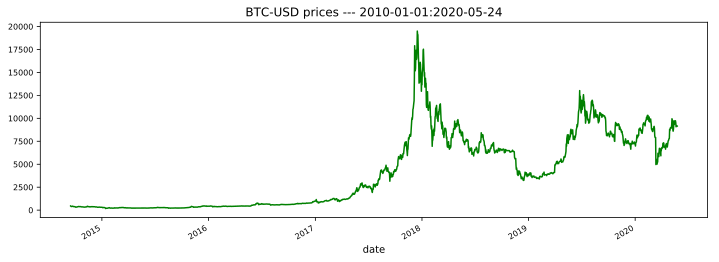

In [46]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2010-01-01', 
                  end_date='2020-05-24', 
                  freq='daily', 
                  path='data/BTC.csv')

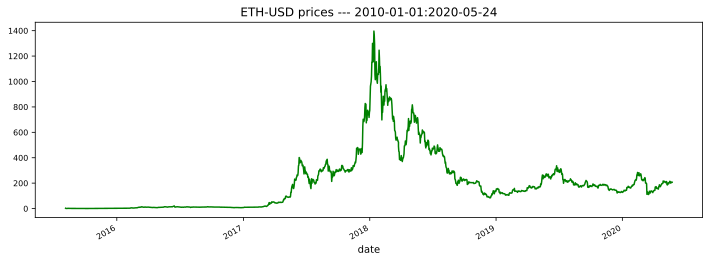

In [47]:
download_csv_data(ticker='ETH-USD', 
                  start_date='2010-01-01', 
                  end_date='2020-05-24', 
                  freq='daily', 
                  path='data/ETH.csv')

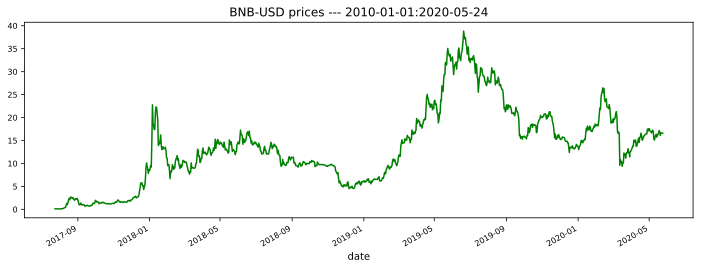

In [48]:
download_csv_data(ticker='BNB-USD', 
                  start_date='2010-01-01', 
                  end_date='2020-05-24', 
                  freq='daily', 
                  path='data/BNB.csv')

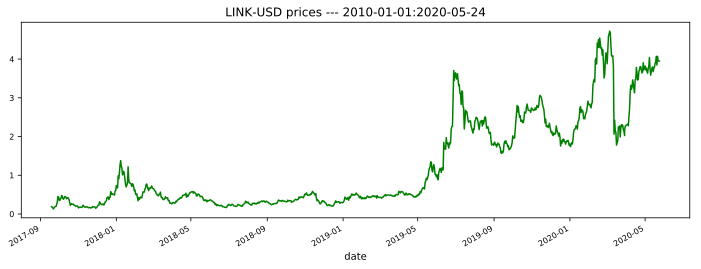

In [49]:
download_csv_data(ticker='LINK-USD', 
                  start_date='2010-01-01', 
                  end_date='2020-05-24', 
                  freq='daily', 
                  path='data/LINK.csv')

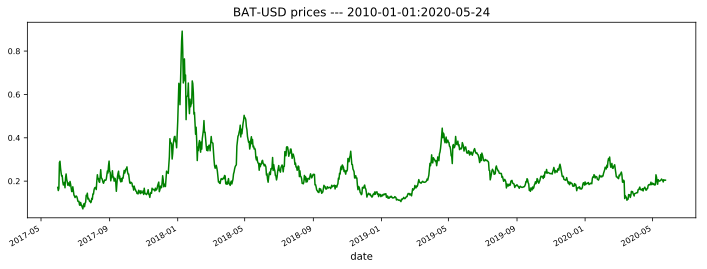

In [50]:
download_csv_data(ticker='BAT-USD', 
                  start_date='2010-01-01', 
                  end_date='2020-05-24', 
                  freq='daily', 
                  path='data/BAT.csv')

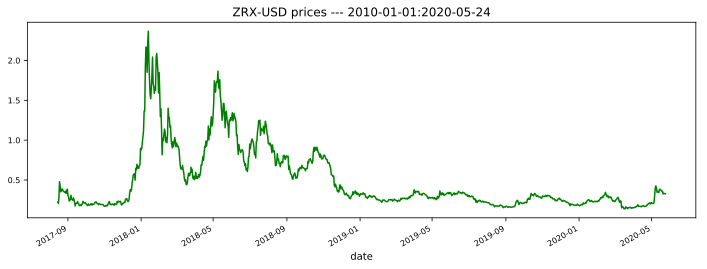

In [51]:
download_csv_data(ticker='ZRX-USD', 
                  start_date='2010-01-01', 
                  end_date='2020-05-24', 
                  freq='daily', 
                  path='data/ZRX.csv')

In [67]:
# Список финансовых инструментов в портфеле

TIKERS = ['BTC', 'ETH', 'BNB', 'LINK', 'BAT', 'ZRX']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose', 'pct_diff']

In [68]:
for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].head())
COLUMNS = ['open', 'close', 'pct_diff']

                  open       close  pct_diff
date                                        
2014-09-16  457.334015  457.334015       NaN
2014-09-17  424.440002  424.440002 -7.192558
2014-09-18  394.795990  394.795990 -6.984265
2014-09-19  408.903992  408.903992  3.573492
2014-09-20  398.821014  398.821014 -2.465854
                open     close   pct_diff
date                                     
2015-08-06  2.772120  2.772120        NaN
2015-08-07  0.753325  0.753325 -72.824950
2015-08-08  0.701897  0.701897  -6.826796
2015-08-09  0.708448  0.708448   0.933323
2015-08-10  1.067860  1.067860  50.732308
                open     close  pct_diff
date                                    
2017-07-24  0.105870  0.105870       NaN
2017-07-25  0.105138  0.105138 -0.691418
2017-07-26  0.107737  0.107737  2.471990
2017-07-27  0.104067  0.104067 -3.406443
2017-07-28  0.107811  0.107811  3.597681
                open     close   pct_diff
date                                     
2017-09-19  0.189165

# Coinmetrics

In [69]:
# Список финансовых инструментов в портфеле
TIKERS = ['XTZ']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['PriceUSD']

In [70]:
for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    #data[tiker] = pd.read_csv("data/{}.csv".format(tiker), parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    
    data[tiker]['index'] = range(0, len(data[tiker]))
    
    data[tiker]['date'] = data[tiker].index
    
    data[tiker] = data[tiker].set_index('index')
    
    data[tiker] = data[tiker].loc[data[tiker]['date'] >= datetime(2018, 6, 30)]
    data[tiker] = data[tiker].loc[data[tiker]['date'] <= datetime(2020, 5, 25)]

    data[tiker] = data[tiker].set_index('date')
    data[tiker] = data[tiker].rename({'PriceUSD': 'close'}, axis=1)
    data[tiker]['open'] = data[tiker]['close']
    data[tiker]['pct_diff'] = data[tiker]['close'].pct_change() * 100
    print(data[tiker].head())
    print(len(data[tiker]))

               close      open   pct_diff
date                                     
2018-06-30  4.391950  4.391950        NaN
2018-07-01  3.898995  3.898995 -11.224056
2018-07-02  2.915169  2.915169 -25.232813
2018-07-03  2.356642  2.356642 -19.159322
2018-07-04  2.231109  2.231109  -5.326773
694


In [71]:
TIKERS = ['BTC', 'ETH', 'BNB', 'XTZ', 'LINK', 'BAT', 'ZRX']

COLUMNS = ['open', 'close', 'pct_diff']

panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 7 (items) x 2078 (major_axis) x 3 (minor_axis)
Items axis: BTC to XTZ
Major_axis axis: 2014-09-16 00:00:00+00:00 to 2020-05-24 00:00:00+00:00
Minor_axis axis: open to pct_diff


# Взаимная корреляция

In [72]:
data_corr = data['BTC']
for tiker in TIKERS:
    data_corr[tiker] = data[tiker]['pct_diff']
del data_corr['open']
del data_corr['close']
del data_corr['pct_diff']
data_corr.corr()

,BTC,ETH,BNB,XTZ,LINK,BAT,ZRX
BTC,1.000000,0.471565,0.532877,0.313353,0.413285,0.502927,0.514469
ETH,0.471565,1.000000,0.495687,0.327952,0.498200,0.622484,0.610403
BNB,0.532877,0.495687,1.000000,0.307158,0.372221,0.431159,0.456264
XTZ,0.313353,0.327952,0.307158,1.000000,0.243562,0.228233,0.207011
LINK,0.413285,0.498200,0.372221,0.243562,1.000000,0.434361,0.450499
BAT,0.502927,0.622484,0.431159,0.228233,0.434361,1.000000,0.566699
ZRX,0.514469,0.610403,0.456264,0.207011,0.450499,0.566699,1.000000


# Risk

### Определяем стартовые переменные

In [109]:
num_assets = len(TIKERS)
performance_list = []
COMMISSION = 0


# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

In [110]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))

    #set_benchmark(symbol('BTC'))

    context.tikers = ['BTC']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2018, 6, 30, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 5, 24, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [111]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))

    #set_benchmark(symbol('BTC'))

    context.tikers = ['ETH']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2018, 6, 30, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 5, 24, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [112]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))

    #set_benchmark(symbol('BTC'))

    context.tikers = ['BNB']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2018, 6, 30, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 5, 24, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [113]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))

    #set_benchmark(symbol('BTC'))

    context.tikers = ['XTZ']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2018, 6, 30, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 5, 24, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [114]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))

    #set_benchmark(symbol('BTC'))

    context.tikers = ['LINK']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2018, 6, 30, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 5, 24, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [115]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))

    #set_benchmark(symbol('BTC'))

    context.tikers = ['BAT']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2018, 6, 30, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 5, 24, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [116]:
WEIGHTS = [0] * num_assets
WEIGHTS[0] = 1
    
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))

    #set_benchmark(symbol('BTC'))

    context.tikers = ['ZRX']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2018, 6, 30, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 5, 24, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

# Визуализация результатов

In [117]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(TIKERS):
    portfolio[symbol] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock for stock in TIKERS]

# reorder dataframe columns
df = df[column_order]

In [118]:
df.head(9)

,Returns,Volatility,Sharpe Ratio,BTC,ETH,BNB,XTZ,LINK,BAT,ZRX
0,19.429219,73.813168,0.623626,1,0,0,0,0,0,0
1,-35.008032,97.055503,0.064668,1,0,0,0,0,0,0
2,9.223403,92.603490,0.580452,1,0,0,0,0,0,0
3,7.662932,82.467381,0.511866,1,0,0,0,0,0,0
4,343.265452,130.042090,1.787224,1,0,0,0,0,0,0
5,-11.629555,112.514154,0.471635,1,0,0,0,0,0,0
6,-47.397069,146.493350,0.291204,1,0,0,0,0,0,0


In [119]:
asset_list = TIKERS

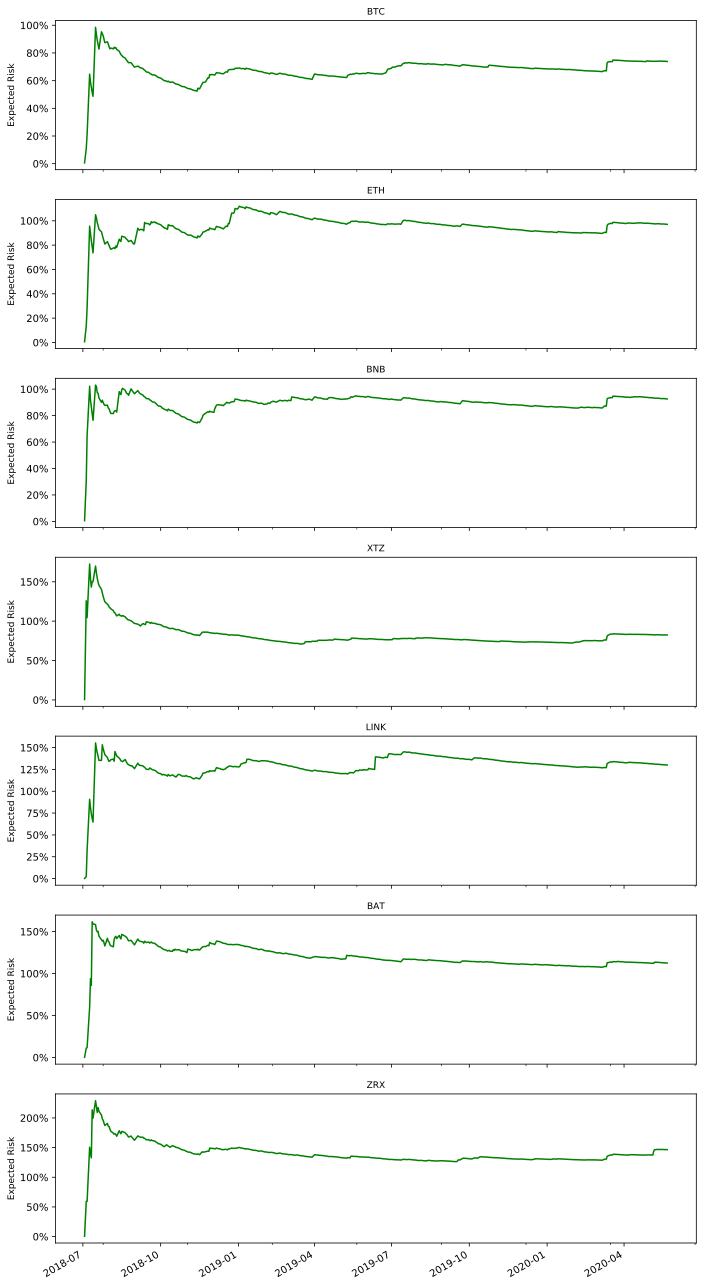

In [120]:
risk_list = []

fig, ax = plt.subplots(len(TIKERS), 1, sharex=True, figsize=[11.5, 25])

for i in range(0, len(TIKERS)):
    risk_list.append(performance_list[i].algo_volatility * 100)
    risk_list[i].plot(ax=ax[i], color='g')
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[i].set_ylabel('Expected Risk', fontsize = 9)
    ax[i].set_title(asset_list[i], fontsize = 9)

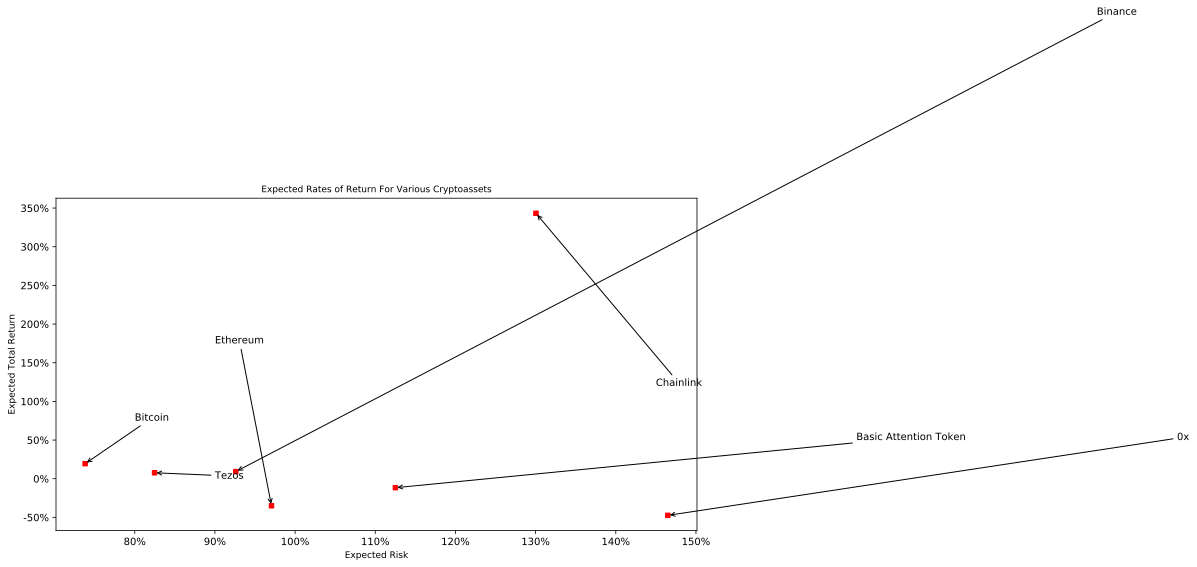

In [121]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
ax = df.plot.scatter(x='Volatility', y='Returns', marker = 's', color='r', edgecolors='r', figsize=(11.5, 6))
plt.xlabel('Expected Risk', fontsize = 9)
plt.ylabel('Expected Total Return', fontsize = 9)
plt.title('Expected Rates of Return For Various Cryptoassets', fontsize = 9)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
#ax.set(xlim=(50, 250), ylim=(-50, 300))

#https://matplotlib.org/3.1.1/tutorials/text/annotations.html

plt.annotate('Bitcoin', xy=(df.iloc[0]['Volatility'], df.iloc[0]['Returns']), xytext=(80, 75),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Ethereum', xy=(df.iloc[1]['Volatility'], df.iloc[1]['Returns']), xytext=(90, 175),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Binance', xy=(df.iloc[2]['Volatility'], df.iloc[2]['Returns']), xytext=(200, 600),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Tezos', xy=(df.iloc[3]['Volatility'], df.iloc[3]['Returns']), xytext=(90, 0),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Chainlink', xy=(df.iloc[4]['Volatility'], df.iloc[4]['Returns']), xytext=(145, 120),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Basic Attention Token', xy=(df.iloc[5]['Volatility'], df.iloc[5]['Returns']), xytext=(170, 50),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('0x', xy=(df.iloc[6]['Volatility'], df.iloc[6]['Returns']), xytext=(210, 50),
             arrowprops=dict(arrowstyle="->"))

plt.show()

In [122]:
Corr = data_corr.corr()
Corr = Corr.as_matrix()

In [123]:
V = Corr.copy()

In [124]:
w0 = df['Volatility']/100
w0 = w0.values.tolist()

In [125]:
for i in range(0, len(Corr)):
    for j in range(0, len(Corr)):
        V[i][j] = Corr[i][j] * w0[i] * w0[j]

In [126]:
TIKERS = ['BTC', 'ETH', 'BNB', 'XTZ', 'LINK', 'BAT', 'ZRX']

In [127]:
x_t = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] # your risk budget percent of total portfolio risk (equal risk)

cons = ({'type': 'eq', 'fun': total_weight_constraint}, {'type': 'ineq', 'fun': long_only_constraint})

res= minimize(risk_budget_objective, w0, args=[V,x_t], method='SLSQP',constraints=cons, options={'disp': True})

w_rb = np.asmatrix(res.x)

w_rb = w_rb.tolist()[0]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.006271164272404357
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 8


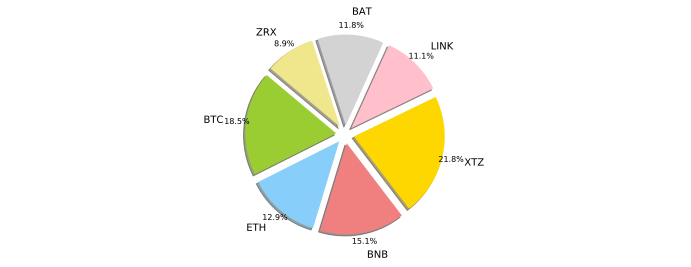

In [128]:
# Data to plot
labels = TIKERS
sizes = w_rb
colors = ['yellowgreen', 'lightskyblue', 'lightcoral', 'gold', 'pink' , 'lightgrey', 'khaki']
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)  # explode 1st slice

# Plot
weight_pie = plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140, textprops={'fontsize': 8}, pctdistance=1.1, labeldistance=1.25)

plt.axis('equal')
#plt.legend(labels, loc="best")
plt.show()